In [6]:
import numpy as np
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import config

class MapDataset(Dataset):
    def __init__(self, root_dir):
        super().__init__()

        self.root_dir = root_dir
        self.list_files = os.listdir(root_dir)
        print(self.list_files)
    
    def __len__(self):
        return len(self.list_files)
    
    def __getitem__(self, index):
        image_path = self.list_files[index]
        file_path = os.path.join(self.root_dir, image_path)
        image = np.array(Image.open(file_path))
        input_image = image[:, :256, :]
        inter_image = image[:, 256:512, :]
        target_image = image[:, 512:, :]

        input_image = config.transform_only_input(image=input_image)["image"]
        inter_image = config.transform_only_input(image=inter_image)["image"]
        target_image = config.transform_only_mask(image=target_image)["image"]

        return input_image, inter_image, target_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ls ['img']
input data shape: (128, 128, 14)
data ndvi shape  (128, 128) f_data shape:  (1, 128, 128, 3)


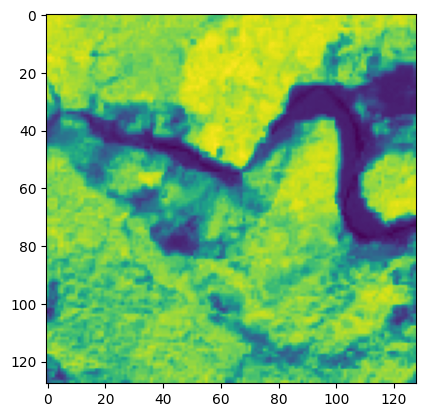

In [25]:

path_single = r"image_dataset/landslide/TrainData/img/image_2000.h5"
path_single_mask = r'image_dataset/landslide/TrainData/mask/mask_2000.h5'

f_data = np.zeros((1, 128,128, 3))
with h5py.File(path_single) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)
    plt.imshow(data[:, :, 3:0:-1])
    
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_rgb = data[:, :, 3:0:-1]
    data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
    f_data[0, :, :, 0] =data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]

    print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
    plt.imshow(data_ndvi)

ls ['mask']
input data shape: (128, 128)


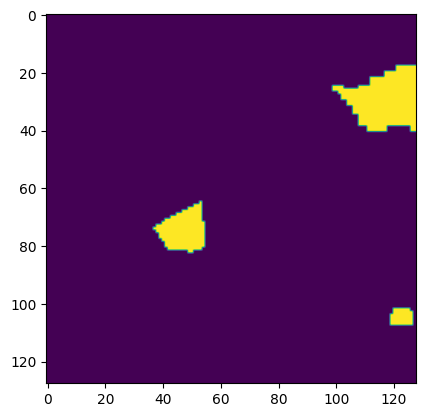

In [26]:
with h5py.File(path_single_mask) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('mask'))
    print("input data shape:", data.shape)
    plt.imshow(data)

In [37]:
import glob

path_single = r"image_dataset/landslide/TrainData/image_10.h5"
path_single_mask = r'image_dataset/landslide/TrainData/mask/mask_1.h5'
TRAIN_PATH = r"image_dataset/landslide/TrainData/img/*.h5"
TRAIN_MASK = r'image_dataset/landslide/TrainData/mask/*.h5'

TRAIN_XX = np.zeros((3799, 128, 128, 7))
TRAIN_YY = np.zeros((3799, 128, 128, 1))
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

In [140]:
from tqdm import tqdm

def load_in_ram(XX, YY, all_train, all_mask):
    for i, (img, mask) in tqdm(enumerate(zip(all_train, all_mask))):
        # print(i, img, mask)
        with h5py.File(img) as hdf:
            ls = list(hdf.keys())
            data = np.array(hdf.get('img'))

            # assign 0 for the nan value
            data[np.isnan(data)] = 0.000001

            # to normalize the data 
            mid_rgb = data[:, :, 1:4].max() / 2.0
            mid_slope = data[:, :, 12].max() / 2.0
            mid_elevation = data[:, :, 13].max() / 2.0

            # ndvi calculation
            data_red = data[:, :, 3]
            data_nir = data[:, :, 7]
            data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))

            ndwi = np.divide(data_green - data_nir, data_green + data_nir, 
                    out=np.zeros_like(data_green, dtype=float), 
                    where=(data_green + data_nir) != 0)
            
            # final array
            XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
            XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
            XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
            XX[i, :, :, 3] = data_ndvi #NDVI
            XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
            XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION
            XX[i, :, :, 6] = ndwi  #NDWI
        
        
        with h5py.File(mask) as hdf:
            ls = list(hdf.keys())
            data=np.array(hdf.get('mask'))
            YY[i, :, :, 0] = data
    
    return XX, YY

In [ ]:
TRAIN_XX, TRAIN_YY = load_in_ram(TRAIN_XX, TRAIN_YY, all_train, all_mask)

In [63]:
TRAIN_XX[img, :, :, 0:3].shape

(128, 128, 3)

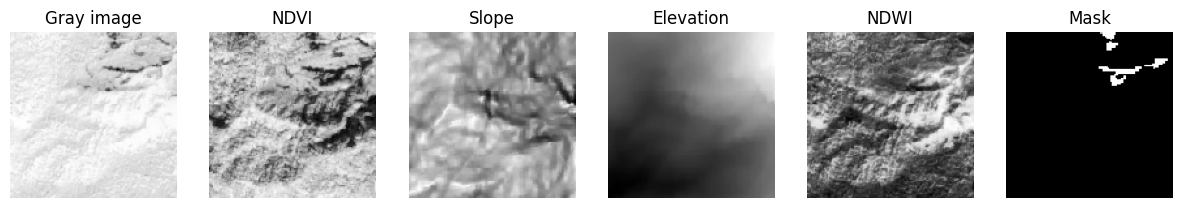

In [113]:
img=654
import cv2
fig,(ax1,ax2, ax3, ax4, ax5, ax6)= plt.subplots(1,6,figsize=(15,10))

gray_image = cv2.cvtColor(TRAIN_XX[img, :, :, 0:3].astype(np.float32), cv2.COLOR_BGR2GRAY)
NDVI = TRAIN_XX[img, :, :, 3]
Slope = TRAIN_XX[img, :, :, 4]
Elevation = TRAIN_XX[img, :, :, 5]
NDWI = TRAIN_XX[img, :, :, 6]
Mask = TRAIN_YY[img, :, :, 0]

ax1.set_title("Gray image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("NDWI")
ax6.set_title("Mask")

ax1.imshow(gray_image, cmap="gray")
ax2.imshow(NDVI, cmap="gray")
ax3.imshow(Slope, cmap="gray")
ax4.imshow(Elevation, cmap="gray")
ax5.imshow(NDWI, cmap="gray")
ax6.imshow(Mask, cmap="gray")

ax1.axis("off"); ax2.axis("off"), ax3.axis("off"); ax4.axis("off"), ax5.axis("off"); ax6.axis("off")
plt.show()

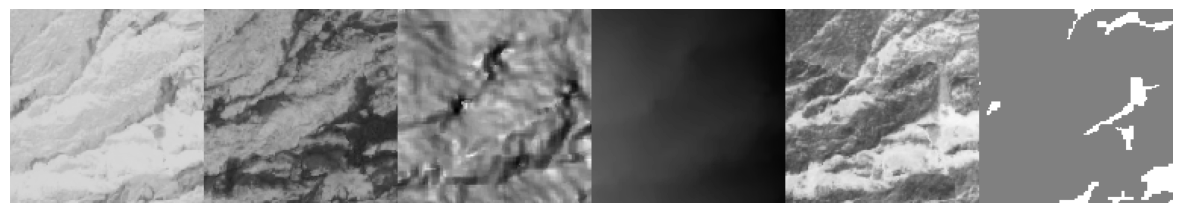

In [135]:
def create_canvas(XX, YY, img, save_image="image_dataset/landslide/Train"):

    gray_image = cv2.cvtColor(XX[img, :, :, 0:3].astype(np.float32), cv2.COLOR_BGR2GRAY)
    NDVI = XX[img, :, :, 3]
    Slope = XX[img, :, :, 4]
    Elevation = XX[img, :, :, 5]
    NDWI = XX[img, :, :, 6]
    Mask = YY[img, :, :, 0]
    
    if Mask.max() > 1.0:  # Check if mask values are above 1.0 (e.g., 255 for binary images)
        Mask = Mask / Mask.max()  # Normalize to [0, 1]
    Mask = (Mask >= 0.5).astype(np.float32)


    elements = [gray_image, NDVI, Slope, Elevation, NDWI, Mask]

    canvas_height = 128
    canvas_width = 128 * len(elements)  # Dynamically set based on number of elements
    canvas = np.zeros((canvas_height, canvas_width))

    # Add each element to the canvas
    for i, element in enumerate(elements):
        canvas[0:128, 128 * i:128 * (i + 1)] = element
    if save_image: plt.imsave(f"{save_image}/{img}.jpg", canvas, cmap="gray")
    return canvas

canvas = create_canvas(TRAIN_XX, TRAIN_YY, img=234, save_image=None)

# Display the canvas
plt.figure(figsize=(15, 5))
plt.imshow(canvas, cmap="gray")
plt.axis("off")

plt.show()

In [153]:
TRAIN_XX, TRAIN_YY = load_in_ram(TRAIN_XX, TRAIN_YY, all_train, all_mask)

1666it [00:06, 247.36it/s]/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_18077/1143044048.py:32: RuntimeWarning: invalid value encountered in divide
  XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
2257it [00:09, 234.39it/s]/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_18077/1143044048.py:21: RuntimeWarning: invalid value encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
3799it [00:15, 243.16it/s]


In [ ]:
TRAIN_PATH = r"image_dataset/landslide/TrainData/img/*.h5"
TRAIN_MASK = r'image_dataset/landslide/TrainData/mask/*.h5'

TRAIN_XX = np.zeros((3799, 128, 128, 7))
TRAIN_YY = np.zeros((3799, 128, 128, 1))
all_mask = sorted(glob.glob(TRAIN_MASK))
all_train = sorted(glob.glob(TRAIN_PATH))

# TRAIN_XX, TRAIN_YY = load_in_ram(TRAIN_XX, TRAIN_YY, all_train, all_mask)
for i in tqdm(range(len(TRAIN_XX)), total=len(TRAIN_XX)): 
    create_canvas(TRAIN_XX, TRAIN_YY, img=i)

100%|██████████| 3799/3799 [00:13<00:00, 287.25it/s]


In [22]:
from dataset import Image_dataset
from torch.utils.data import DataLoader

ds = Image_dataset(root_dir="image_dataset/landslide/Train", inter_images=4)
dl = DataLoader(ds, shuffle=True)
x, z1, z2, z3, z4, y = next(iter(dl))
print("Input image: ", x.shape)
print("Inter1 image: ", z1.shape)
print("Inter2 image: ", z2.shape)
print("Inter3 image: ", z3.shape)
print("Inter4 image: ", z4.shape)
print("Output/Target image: ", y.shape)

Input image:  torch.Size([1, 3, 128, 128])
Inter1 image:  torch.Size([1, 3, 128, 128])
Inter2 image:  torch.Size([1, 3, 128, 128])
Inter3 image:  torch.Size([1, 3, 128, 128])
Inter4 image:  torch.Size([1, 3, 128, 128])
Output/Target image:  torch.Size([1, 3, 128, 128])


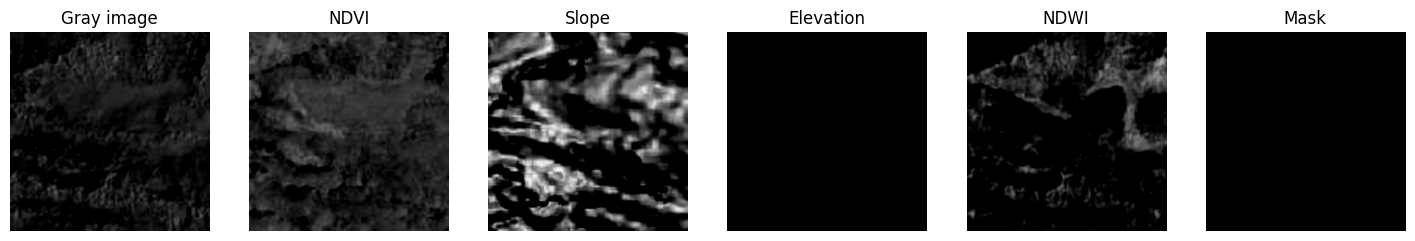

In [137]:
import matplotlib.pyplot as plt
from dataset import Image_dataset
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np

ds = Image_dataset(root_dir="image_dataset/landslide/Test", inter_images=4, binarize_output=False, grayscale_all=False)
dl = DataLoader(ds, shuffle=False)
x, z1, z2, z3, z4, y = next(iter(dl))

fig,(ax1,ax2, ax3, ax4, ax5, ax6)= plt.subplots(1,6,figsize=(18,6))

ax1.set_title("Gray image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("NDWI")
ax6.set_title("Mask")

ax1.imshow(x[0].permute(1,2,0).clip(0,1), cmap="gray")
ax2.imshow(z1[0].permute(1,2,0).clip(0,1), cmap="gray")
ax3.imshow(z2[0].permute(1,2,0).clip(0,1), cmap="gray")
ax4.imshow(z3[0].permute(1,2,0).clip(0,1), cmap="gray")
ax5.imshow(z4[0].permute(1,2,0).clip(0,1), cmap="gray")
ax6.imshow(y[0].permute(1,2,0).clip(0,1), cmap="gray")

ax1.axis("off"); ax2.axis("off"), ax3.axis("off"); ax4.axis("off"), ax5.axis("off"); ax6.axis("off")
plt.show()


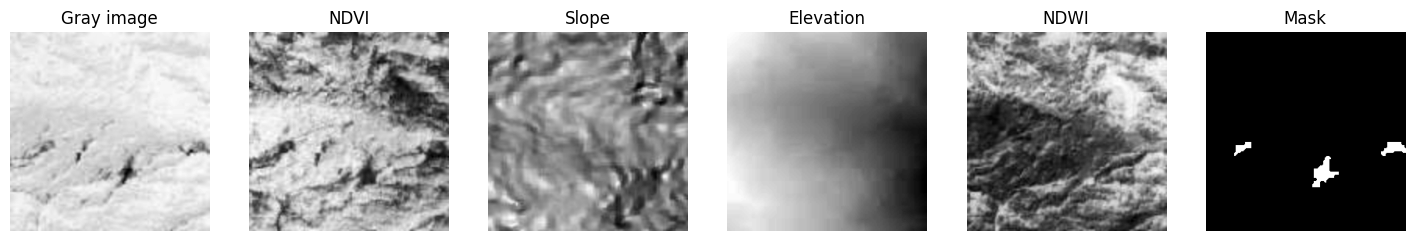

In [13]:
from dataset import Image_dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

ds = Image_dataset("image_dataset/landslide/Test", inter_images=4, binarize_output=True, grayscale_all=True)
dl = DataLoader(ds, shuffle=True)
x, z1, z2, z3, z4, y = next(iter(dl)) 
x, z1, z2, z3, z4 = x*0.5+0.5, z1*0.5+0.5, z2*0.5+0.5, z3*0.5+0.5, z4*0.5+0.5

fig,(ax1,ax2, ax3, ax4, ax5, ax6)= plt.subplots(1,6,figsize=(18,6))

ax1.imshow(x[0].permute(1,2,0).clip(0,1), cmap="gray")
ax2.imshow(z1[0].permute(1,2,0).clip(0,1), cmap="gray")
ax3.imshow(z2[0].permute(1,2,0).clip(0,1), cmap="gray")
ax4.imshow(z3[0].permute(1,2,0).clip(0,1), cmap="gray")
ax5.imshow(z4[0].permute(1,2,0).clip(0,1), cmap="gray")
ax6.imshow(y[0].permute(1,2,0).clip(0,1), cmap="gray")

ax1.set_title("Gray image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("NDWI")
ax6.set_title("Mask")

ax1.axis("off"); ax2.axis("off"), ax3.axis("off"); ax4.axis("off"), ax5.axis("off"); ax6.axis("off")
plt.show()


(-0.5, 255.5, 255.5, -0.5)

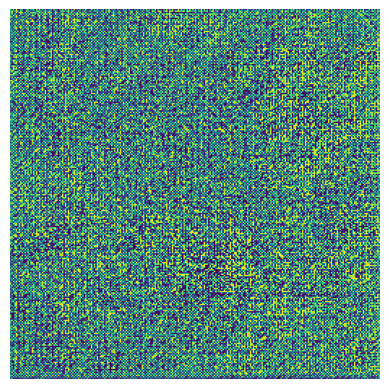

In [21]:
from generator_model import Generator

gen = Generator(in_channels=1, out_channels=1, inter_images=4)
output = gen(x, z1=z1, z2=z2, z3=z3, z4=z4)
plt.imshow(output[0].permute(1,2,0).detach().numpy())
plt.axis("off")

In [5]:
from torch import tensor
import torch
from torchmetrics.classification import Dice

preds  = (torch.rand(2, 1, 128, 128) > 0.5) * 1
target = (torch.rand(2, 1, 128, 128) > 0.5) * 1
dice = Dice(average='micro')
dice(preds, target).items()

AttributeError: 'Tensor' object has no attribute 'items'

In [21]:
import torch

x = torch.tensor(((0.6, 0.4), (0.3, 0.7)))
torch.matmul(x, torch.matmul(x, torch.matmul(x, x)))

tensor([[0.4332, 0.5668],
        [0.4251, 0.5749]])